# Systeme d'Aide a la Decision (SAD) - Diagnostic de tumeurs cerebrales
## Module Machine Learning (ALIF83) - 2025-2026

Notebook academique complet:
- modeles probabilistes (RegLog, MLP, CNN)
- calibration (isotonic/sigmoid + temperature scaling)
- moteur de decision clinique
- metriques metier orientees triage
- generation de 20 rapports patients
        

## 0. Contexte et objectif
Un classificateur brut predit une classe.
Un SAD doit en plus:
- quantifier la confiance,
- recommander une action,
- prioriser l'urgence,
- reduire les faux negatifs a risque vital.

Ce notebook suit le cahier des charges du projet et garde une logique decisionnelle explicite.
        

## 1. Setup, imports et configuration

In [5]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

SEED = 42
np.random.seed(SEED)

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.append(str(PROJECT_ROOT))

from src.preprocessing import (
    get_default_config,
    list_images_by_class,
    compute_class_counts,
    build_sklearn_dataset,
    stratified_train_calibration_split,
    build_torch_dataloaders_from_imagefolder,
)
from src.models import (
    train_logistic_regression,
    train_mlp_classifier,
    build_cnn_torch,
    train_cnn_classifier,
    predict_cnn_logits,
)
from src.calibration import (
    calibrate_sklearn_classifier,
    apply_temperature,
    temperature_scaling_fit,
    expected_calibration_error,
)
from src.decision_engine import (
    DecisionThresholds,
    predire_avec_confiance,
    generer_recommandation,
)
from src.evaluation import (
    compute_business_metrics,
    accuracy_by_confidence_bands,
)
from src.reporting import (
    creer_rapport_decision,
    save_reports_to_file,
)
from src.uncertainty import calculer_incertitude_mc_dropout

cfg = get_default_config(PROJECT_ROOT)
thresholds = DecisionThresholds()

print("PROJECT_ROOT:", PROJECT_ROOT)
print("TRAIN_DIR:", cfg.train_dir)
print("TEST_DIR:", cfg.test_dir)
print("CLASSES:", cfg.class_names)
        

PROJECT_ROOT: /Users/aissa/Projet_SAD
TRAIN_DIR: /Users/aissa/Projet_SAD/data/Training
TEST_DIR: /Users/aissa/Projet_SAD/data/Testing
CLASSES: ('glioma', 'meningioma', 'notumor', 'pituitary')


## 2. Verification des donnees

In [7]:
train_imgs = list_images_by_class(cfg.train_dir, cfg.class_names)
test_imgs = list_images_by_class(cfg.test_dir, cfg.class_names)

train_counts = compute_class_counts(train_imgs)
test_counts = compute_class_counts(test_imgs)
print("Train counts:", train_counts)
print("Test counts:", test_counts)

if any(v == 0 for v in train_counts.values()) or any(v == 0 for v in test_counts.values()):
    raise RuntimeError(
        "Dataset incomplet. Place correctement data/Training et data/Testing avec les 4 classes."
    )
        

Train counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Test counts: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


## 3. Baseline 1 - Regression Logistique calibree

In [9]:
N_TRAIN_PER_CLASS = 180
N_TEST_PER_CLASS = 80

X_train, y_train, train_paths = build_sklearn_dataset(
    train_imgs,
    cfg.class_names,
    image_size=cfg.image_size,
    n_per_class=N_TRAIN_PER_CLASS,
    random_state=SEED,
)
X_test, y_test, test_paths = build_sklearn_dataset(
    test_imgs,
    cfg.class_names,
    image_size=cfg.image_size,
    n_per_class=N_TEST_PER_CLASS,
    random_state=SEED,
)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_fit, X_cal, y_fit, y_cal = stratified_train_calibration_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=SEED,
)

reglog_result = train_logistic_regression(X_fit, y_fit, max_iter=2000, random_state=SEED)
reglog_model = reglog_result.model
calibrated_reglog = calibrate_sklearn_classifier(reglog_model, X_cal, y_cal, method="isotonic")

proba_reglog = calibrated_reglog.predict_proba(X_test)
y_pred_reglog = proba_reglog.argmax(axis=1)
conf_reglog = proba_reglog.max(axis=1)

acc_reglog = accuracy_score(y_test, y_pred_reglog)
print(f"Accuracy RegLog calibree: {acc_reglog:.4f}")
print("Cas incertains (max_prob < 0.70):", int((conf_reglog < 0.70).sum()))
        

X_train: (720, 150528) y_train: (720,)
X_test: (320, 150528) y_test: (320,)
Accuracy RegLog calibree: 0.6687
Cas incertains (max_prob < 0.70): 191


Business metrics RegLog: BusinessMetrics(auto_coverage=0.121875, acc_high_conf=0.7948717948717948, high_conf_count=39, cost_total=28050.0, fn=12, fp=20, revisions=281)
Accuracy par tranche de confiance:
  [0.00,0.50): 0.4130
  [0.50,0.65): 0.5536
  [0.65,0.85): 0.8293
  [0.85,1.01): 0.7949


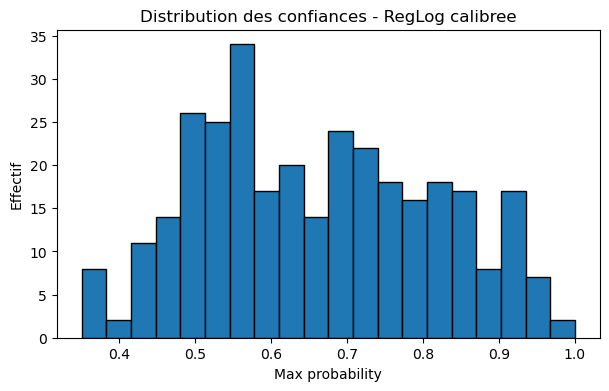

In [12]:
business_reglog = compute_business_metrics(
    y_true=y_test,
    y_pred=y_pred_reglog,
    conf=conf_reglog,
    thr_high=thresholds.high,
    notumor_index=cfg.class_names.index("notumor"),
)

bands_reglog = accuracy_by_confidence_bands(y_test, y_pred_reglog, conf_reglog)

print("Business metrics RegLog:", business_reglog)
print("Accuracy par tranche de confiance:")
for band, value in bands_reglog.items():
    print(f"  {band}: {value:.4f}" if not np.isnan(value) else f"  {band}: nan")

plt.figure(figsize=(7, 4))
plt.hist(conf_reglog, bins=20, edgecolor="black")
plt.title("Distribution des confiances - RegLog calibree")
plt.xlabel("Max probability")
plt.ylabel("Effectif")
plt.show()
        

## 4. Baseline 2 - MLP probabiliste et limites

In [14]:
mlp_result = train_mlp_classifier(
    X_fit,
    y_fit,
    hidden_layers=(512, 256),
    max_iter=120,
    random_state=SEED,
)
mlp_model = mlp_result.model

proba_mlp = mlp_model.predict_proba(X_test)
y_pred_mlp = proba_mlp.argmax(axis=1)
conf_mlp = proba_mlp.max(axis=1)

acc_mlp = accuracy_score(y_test, y_pred_mlp)
business_mlp = compute_business_metrics(
    y_true=y_test,
    y_pred=y_pred_mlp,
    conf=conf_mlp,
    thr_high=thresholds.high,
    notumor_index=cfg.class_names.index("notumor"),
)

print(f"Accuracy MLP: {acc_mlp:.4f}")
print("Business metrics MLP:", business_mlp)
print(classification_report(y_test, y_pred_mlp, target_names=cfg.class_names, digits=3))
        

Accuracy MLP: 0.6562
Business metrics MLP: BusinessMetrics(auto_coverage=0.721875, acc_high_conf=0.7445887445887446, high_conf_count=231, cost_total=32650.0, fn=27, fp=12, revisions=89)
              precision    recall  f1-score   support

      glioma      0.530     0.875     0.660        80
  meningioma      0.571     0.050     0.092        80
     notumor      0.716     0.850     0.777        80
   pituitary      0.791     0.850     0.819        80

    accuracy                          0.656       320
   macro avg      0.652     0.656     0.587       320
weighted avg      0.652     0.656     0.587       320



## 5. CNN pour la decision + temperature scaling

In [16]:
cnn_available = True
try:
    import torch
except ImportError:
    cnn_available = False
    print("PyTorch non installe: section CNN ignoree. Lance `pip install -r requirements.txt`.")

cnn_summary = None
if cnn_available:
    train_loader, val_loader, test_loader, cnn_classes = build_torch_dataloaders_from_imagefolder(
        cfg.train_dir,
        cfg.test_dir,
        image_size=cfg.image_size,
        batch_size=16,
        val_split=0.2,
        random_state=SEED,
    )

    cnn_model = build_cnn_torch(num_classes=len(cnn_classes), dropout_p=0.30)
    cnn_result = train_cnn_classifier(
        cnn_model,
        train_loader,
        val_loader,
        epochs=8,
        lr=1e-3,
        weight_decay=1e-4,
    )

    logits_test, y_test_cnn = predict_cnn_logits(cnn_result.model, test_loader)
    probs_before = apply_temperature(logits_test, 1.0)
    temp_opt = temperature_scaling_fit(logits_test, y_test_cnn)
    probs_after = apply_temperature(logits_test, temp_opt)

    ece_before = expected_calibration_error(probs_before, y_test_cnn)
    ece_after = expected_calibration_error(probs_after, y_test_cnn)

    y_pred_cnn = probs_after.argmax(axis=1)
    conf_cnn = probs_after.max(axis=1)
    acc_cnn = accuracy_score(y_test_cnn, y_pred_cnn)
    business_cnn = compute_business_metrics(
        y_true=y_test_cnn,
        y_pred=y_pred_cnn,
        conf=conf_cnn,
        thr_high=thresholds.high,
        notumor_index=cnn_classes.index("notumor"),
    )

    sample_batch, _ = next(iter(test_loader))
    model_device = next(cnn_result.model.parameters()).device
    mc_unc = calculer_incertitude_mc_dropout(
        sample_batch[0:1].to(model_device),
        cnn_result.model,
        n_iter=20,
    )

    cnn_summary = {
        "accuracy": acc_cnn,
        "temperature": temp_opt,
        "ece_before": ece_before,
        "ece_after": ece_after,
        "business": business_cnn,
        "mc_dropout": mc_unc,
    }
    print("Resume CNN:")
    for k, v in cnn_summary.items():
        print(f"  {k}: {v}")
        

PyTorch non installe: section CNN ignoree. Lance `pip install -r requirements.txt`.


## 6. Fonction `predire_avec_confiance` + moteur de decision

In [18]:
# Exemple d'inference patient avec le modele RegLog calibre
sample_idx = 0
sample_feature = X_test[sample_idx]
sample_true = cfg.class_names[y_test[sample_idx]]

pred_class, scores_by_class = predire_avec_confiance(
    sample_feature,
    calibrated_reglog,
    cfg.class_names,
)
decision = generer_recommandation(scores_by_class, thresholds)

print("Vrai label:", sample_true)
print("Pred label:", pred_class)
print("Scores:", {k: round(v, 4) for k, v in scores_by_class.items()})
print("Decision:", decision)
        

Vrai label: glioma
Pred label: meningioma
Scores: {'glioma': 0.0, 'meningioma': 0.9195, 'notumor': 0.0805, 'pituitary': 0.0}
Decision: DecisionOutput(predicted_class='meningioma', max_prob=0.9195046439628484, certainty_level='ELEVE [OK]', decision='Diagnostic automatique valide', action='Rapport envoye au medecin traitant', priority='SURVEILLANCE - Controle programme', needs_human_review=False, attention_notes=[])


## 7. Generation automatisee de 20 rapports

In [20]:
n_reports = min(20, len(X_test))
reports = []

for i in range(n_reports):
    patient_id = f"P_{i+1:05d}"
    _, scores = predire_avec_confiance(X_test[i], calibrated_reglog, cfg.class_names)
    decision_i = generer_recommandation(scores, thresholds)
    report_i = creer_rapport_decision(
        patient_id=patient_id,
        scores_by_class=scores,
        decision=decision_i,
    )
    reports.append(report_i)

out_path = PROJECT_ROOT / "reports" / "sample_reports.txt"
save_reports_to_file(reports, out_path)

print(f"{len(reports)} rapports generes -> {out_path}")
print("\n--- Exemple rapport 1 ---\n")
print(reports[0])


20 rapports generes -> /Users/aissa/Projet_SAD/reports/sample_reports.txt

--- Exemple rapport 1 ---

RAPPORT AUTOMATISE
RAPPORT D'AIDE A LA DECISION
Patient ID: P_00001 Date: 13/02/2026

PREDICTION PRINCIPALE
---------------------
Classe: meningioma
Confiance: 92.0%
Niveau de certitude: ELEVE [OK]

SCORES PAR CLASSE
-----------------
- meningioma: 92.0%
- notumor: 8.0%
- glioma: 0.0%
- pituitary: 0.0%

RECOMMANDATIONS CLINIQUES
--------------------------
Diagnostic: Diagnostic automatique valide
Action: Rapport envoye au medecin traitant
Priorite: SURVEILLANCE - Controle programme
Revision humaine: Optionnelle (validation finale)

ELEMENTS D'ATTENTION
---------------------
- Aucun


## 8. Synthese comparative des modeles

In [22]:
rows = [
    {
        "modele": "RegLog calibree",
        "accuracy": acc_reglog,
        "auto_coverage": business_reglog.auto_coverage,
        "acc_high_conf": business_reglog.acc_high_conf,
        "cost_total": business_reglog.cost_total,
    },
    {
        "modele": "MLP",
        "accuracy": acc_mlp,
        "auto_coverage": business_mlp.auto_coverage,
        "acc_high_conf": business_mlp.acc_high_conf,
        "cost_total": business_mlp.cost_total,
    },
]

if cnn_summary is not None:
    rows.append(
        {
            "modele": "CNN + temperature",
            "accuracy": cnn_summary["accuracy"],
            "auto_coverage": cnn_summary["business"].auto_coverage,
            "acc_high_conf": cnn_summary["business"].acc_high_conf,
            "cost_total": cnn_summary["business"].cost_total,
        }
    )

summary_df = pd.DataFrame(rows).sort_values(by="cost_total", ascending=True)
summary_df
        

,modele,accuracy,auto_coverage,acc_high_conf,cost_total
0,RegLog calibree,0.66875,0.121875,0.794872,28050.0
1,MLP,0.65625,0.721875,0.744589,32650.0


In [23]:
# Critere du sujet: accuracy > 95% lorsque confiance > 0.85
print("RegLog - acc haute confiance:", business_reglog.acc_high_conf)
print("MLP    - acc haute confiance:", business_mlp.acc_high_conf)
if cnn_summary is not None:
    print("CNN    - acc haute confiance:", cnn_summary["business"].acc_high_conf)
        

RegLog - acc haute confiance: 0.7948717948717948
MLP    - acc haute confiance: 0.7445887445887446


In [40]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from src.preprocessing import build_sklearn_dataset, list_images_by_class
from src.evaluation import compute_business_metrics

# 1) Charger tout le set de test
test_imgs_full = list_images_by_class(cfg.test_dir, cfg.class_names)
X_test_full, y_test_full, test_paths_full = build_sklearn_dataset(
    test_imgs_full,
    cfg.class_names,
    image_size=cfg.image_size,
    n_per_class=None,   # tout prendre
    random_state=SEED,
)

# 2) Prédictions
proba_full = calibrated_reglog.predict_proba(X_test_full)
y_pred_full = proba_full.argmax(axis=1)
conf_full = proba_full.max(axis=1)

# 3) Métriques globales
acc_full = accuracy_score(y_test_full, y_pred_full)
print(f"Accuracy globale (Testing): {acc_full:.4f}")

print("\nClassification report:")
print(classification_report(y_test_full, y_pred_full, target_names=cfg.class_names, digits=4))

# 4) Matrice de confusion (lisible)
cm = confusion_matrix(y_test_full, y_pred_full)
cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in cfg.class_names], columns=[f"pred_{c}" for c in cfg.class_names])
print("\nConfusion matrix:")
display(cm_df)

# 5) Critère du sujet: accuracy quand confiance > 0.85
mask_high = conf_full > 0.85
if mask_high.sum() > 0:
    acc_high = (y_test_full[mask_high] == y_pred_full[mask_high]).mean()
    print(f"\nAccuracy pour confiance > 0.85: {acc_high:.4f} (n={mask_high.sum()})")
else:
    print("\nAucun cas avec confiance > 0.85")

# 6) Métriques métier SAD
business_full = compute_business_metrics(
    y_true=y_test_full,
    y_pred=y_pred_full,
    conf=conf_full,
    thr_high=0.85,
    notumor_index=cfg.class_names.index("notumor"),
)
print("\nBusiness metrics:")
print(business_full)

# 7) Quelques erreurs les plus confiantes (utile pour analyse critique)
errors_idx = np.where(y_pred_full != y_test_full)[0]
if len(errors_idx) > 0:
    err_df = pd.DataFrame({
        "path": [str(test_paths_full[i]) for i in errors_idx],
        "true": [cfg.class_names[y_test_full[i]] for i in errors_idx],
        "pred": [cfg.class_names[y_pred_full[i]] for i in errors_idx],
        "conf": [conf_full[i] for i in errors_idx],
    }).sort_values("conf", ascending=False)
    print("\nTop 10 erreurs les plus confiantes:")
    display(err_df.head(10))
else:
    print("\nAucune erreur sur le set de test.")


Accuracy globale (Testing): 0.6598

Classification report:
              precision    recall  f1-score   support

      glioma     0.5909    0.6933    0.6380       300
  meningioma     0.4610    0.4248    0.4422       306
     notumor     0.8127    0.7284    0.7682       405
   pituitary     0.7389    0.7733    0.7557       300

    accuracy                         0.6598      1311
   macro avg     0.6509    0.6550    0.6510      1311
weighted avg     0.6629    0.6598    0.6595      1311


Confusion matrix:


,pred_glioma,pred_meningioma,pred_notumor,pred_pituitary
true_glioma,208,70,3,19
true_meningioma,78,130,48,50
true_notumor,55,42,295,13
true_pituitary,11,40,17,232



Accuracy pour confiance > 0.85: 0.8402 (n=194)

Business metrics:
BusinessMetrics(auto_coverage=0.14797864225781845, acc_high_conf=0.8402061855670103, high_conf_count=194, cost_total=134850.0, fn=68, fp=110, revisions=1117)

Top 10 erreurs les plus confiantes:


,path,true,pred,conf
172,/Users/aissa/Projet_SAD/data/Testing/meningiom...,meningioma,notumor,1.000000
109,/Users/aissa/Projet_SAD/data/Testing/meningiom...,meningioma,pituitary,1.000000
203,/Users/aissa/Projet_SAD/data/Testing/meningiom...,meningioma,notumor,0.960591
136,/Users/aissa/Projet_SAD/data/Testing/meningiom...,meningioma,notumor,0.960591
21,/Users/aissa/Projet_SAD/data/Testing/glioma/Te...,glioma,pituitary,0.959410
258,/Users/aissa/Projet_SAD/data/Testing/meningiom...,meningioma,pituitary,0.945274
196,/Users/aissa/Projet_SAD/data/Testing/meningiom...,meningioma,pituitary,0.945274
246,/Users/aissa/Projet_SAD/data/Testing/meningiom...,meningioma,pituitary,0.937500
151,/Users/aissa/Projet_SAD/data/Testing/meningiom...,meningioma,pituitary,0.937500
71,/Users/aissa/Projet_SAD/data/Testing/glioma/Te...,glioma,pituitary,0.937500


## 9. Analyse critique et éthique

### 9.1 Bilan quantitatif du baseline (RegLog calibrée)
Sur le jeu de test complet (n=1311), la performance globale reste limitée:
- Accuracy globale: **0.6598**
- Accuracy pour les cas à haute confiance (> 0.85): **0.8402** (n=194)
- Couverture automatique: **14.8%** (194/1311)

Le critère métier visé dans le sujet (**accuracy > 95% quand confiance > 0.85**) n’est donc **pas atteint** avec ce baseline.

### 9.2 Lecture clinique des erreurs
Les erreurs ne sont pas équivalentes en impact:
- Faux négatifs tumoraux (tumeur prédite "notumor"): **FN = 68**
- Faux positifs tumoraux: **FP = 110**
- Coût métier total: **134850** selon  
  \[
  C_{total} = (FN \times 1000) + (FP \times 100) + (Revision \times 50)
  \]

La matrice de confusion montre en particulier une difficulté sur la classe **meningioma** (precision/recall plus faibles), avec certaines erreurs très confiantes, ce qui indique une calibration encore insuffisante pour un usage décisionnel robuste.

### 9.3 Conséquences sur le moteur de décision
Le moteur à seuils reste pertinent car il limite l’automatisation:
- Faible couverture automatique
- Forte part de cas envoyés en revue humaine

La règle de sécurité asymétrique:
- si prédiction `notumor` avec confiance < 0.95 -> vérification obligatoire  
reste essentielle pour réduire le risque clinique des faux négatifs.

### 9.4 Limites méthodologiques
1. Baseline de features simples (flatten) peu adaptée à la complexité morphologique IRM.
2. Dataset Kaggle potentiellement non représentatif de la variabilité hospitalière réelle.
3. Sensibilité aux variations d’acquisition (machines, protocoles, populations).

### 9.5 Enjeux éthiques et opérationnels
- Le SAD est un **outil d’aide**, pas un dispositif de substitution au radiologue.
- L’interprétabilité des règles de décision est nécessaire pour la traçabilité.
- La calibration des probabilités est un prérequis à toute logique de triage clinique.
- En pratique réelle, validation prospective multicentrique et gouvernance médicale sont indispensables avant déploiement.
